In this notebook, I will be modeling EAD (Exposure at Default). This refers to the maximum amount of money a bank can lose, given the borrower defaults. Given the Lending Club Dataset, this refers to the maximum amount investors can lose, should the borrower decide to default. The accurate estimation of EAD helps lenders better understand their potential loss exposure and the allocation of collateral more effectively. For defaulted loans, EAD refers to the **outstanding principal balance** (remaining unpaid amount when borrowers default). Simply put, it just refers to **how much money is still left unpaid at the moment the borrower stops repaying**.

We will be using a **Multiple Linear Regression Model** to model EAD. This is because this belongs to a supervised learning approach, where we are going to predict a continuous variable (outstanding principal balance). Furthermore, it serves as a good and interpretable baseline models, to benchmark against more complex algortihms / challenger models.

The following steps will be executed in this notebook:

1. Data Preparation (Removal of irrelevant variables, Remove Post Loan Origination Features, Derive Target Variables & Features)
2. Feature Engineering (Create Interaction Features)
3. Handling Outliers & Skewness
4. Multicollinearity Handling & & Feature Selection
5. Training MLR Model
6. Inspect Model Diagnostics (F-Test)
7. Model Evaluation

Throughout the above process, we will be quickly training our model, and logging it to inspect model performance throughout the notebook.

# 0. Import Libraries


In [1]:
# === Standard libraries ===

import os
import warnings
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)

# === WandB Logging  ===
import wandb

wandb.login(key=os.getenv("WANDB_API_KEY"))

# == Global Functions ==
from functions import *


# === Spark Session & Functions ===
from init_spark import start_spark
import math

spark = start_spark()
from pyspark.sql.functions import (
    col,
    when,
    count,
    desc,
    isnan,
    isnull,
    lit,
    length,
    trim,
    lower,
    upper,
    to_date,
    concat_ws,
    regexp_extract,
    mean,
)
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    DoubleType,
    IntegerType,
    DateType,
    NumericType,
    FloatType,
    LongType,
)


# === Pandas Dataframe & WoE Binning ===
import pandas as pd
from tabulate import tabulate
import numpy as np
from pandas import DataFrame, Series

# == Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning ===
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler  # MinMaxScaler for normalization
from sklearn.linear_model import LinearRegression


# === Load Environment Variables ===
from dotenv import load_dotenv

load_dotenv()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/21 23:46:10 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/0

4.0.0


True

In [2]:
# -----------
#  Constants
# -----------
NOTEBOOK_RUN_NAME = "EAD Model Building"
MODEL_NAME = "MLR Model"

In [3]:
# --------------------
#  Reusable Functions
# --------------------


def train_test_split_oot(pdf):
    pdf_sorted = pdf.sort_values("issue_d", ascending=True)
    split_idx = int(len(pdf_sorted) * 0.8)
    train_pdf = pdf_sorted.iloc[:split_idx]
    test_pdf = pdf_sorted.iloc[split_idx:]

    display(train_pdf.head())
    display(test_pdf.head())

    return train_pdf, test_pdf


def winsorise_col_pd(
    df: pd.DataFrame,
    col_name: str,
    operator: str,
    condition_val: float,
    final_val: float,
) -> pd.DataFrame:
    """
    Winsorises a column by replacing values above/below a cutoff with a fixed value.

    Args:
        df (pd.DataFrame): The input DataFrame.
        col_name (str): Column to winsorise.
        operator (str): Condition operator ("<" or ">").
        condition_val (float): Threshold for condition.
        final_val (float): Value to replace with.

    Returns:
        pd.DataFrame: DataFrame with winsorised column.
    """
    print(f"✅ Winsorising column: {col_name} ...")

    if operator == "<":
        df[col_name] = np.where(df[col_name] < condition_val, final_val, df[col_name])
    elif operator == ">":
        df[col_name] = np.where(df[col_name] > condition_val, final_val, df[col_name])
    else:
        raise ValueError("Operator must be '<' or '>'")
    return df


def retain_rows_pd(
    df: pd.DataFrame, col_name: str, condition_val: float, operator: str
) -> pd.DataFrame:
    """
    Retains rows where the column meets the condition.

    Args:
        df (pd.DataFrame): The input DataFrame.
        col_name (str): Column to filter on.
        condition_val (float): Cutoff for condition.
        operator (str): One of '<=', '<', '>', '>='.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    if operator == "<=":
        return df[df[col_name] <= condition_val]
    elif operator == "<":
        return df[df[col_name] < condition_val]
    elif operator == ">":
        return df[df[col_name] > condition_val]
    elif operator == ">=":
        return df[df[col_name] >= condition_val]
    else:
        raise ValueError("Operator must be one of '<=', '<', '>', '>='")


def compute_outlier_pct_pd(s: pd.Series) -> float:
    """Return % of outliers in a pandas Series using IQR rule."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0.0
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_count = ((s < lower) | (s > upper)).sum()
    return outlier_count / len(s) * 100


def inspect_outliers_pd(
    df: pd.DataFrame,
    columns: list,
    sample_size: int = 5,
    method: str = "iqr",  # "iqr" or "percentile"
    lower_pct: float = 0.01,
    upper_pct: float = 0.99,
):
    for col in columns:
        print(f"\n📊 Inspecting Outliers for Column: `{col}`")
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        if s.empty:
            print("⚠️ No numeric data; skipping.")
            continue

        if method.lower() == "iqr":
            q1, q3 = s.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            print(f"IQR Method | Q1={q1:.3f}, Q3={q3:.3f}, IQR={iqr:.3f}")
            print(f"Lower Bound={lower:.3f}, Upper Bound={upper:.3f}")
        else:
            q_low, q_high = s.quantile([lower_pct, upper_pct])
            lower, upper = float(q_low), float(q_high)
            print(
                f"Percentile Method | Lower p{int(lower_pct*100)}={lower:.3f}, Upper p{int(upper_pct*100)}={upper:.3f}"
            )

        # Separate masks
        lower_mask = s < lower
        upper_mask = s > upper

        outlier_count = lower_mask.sum() + upper_mask.sum()
        outlier_pct = round(outlier_count / len(s) * 100, 2)
        print(f"Outlier Count: {outlier_count} ({outlier_pct}% of valid {len(s)})")

        if upper_mask.any():
            print(f"\n🔼 Top Outliers (>{upper:.3f}):")
            print(s[upper_mask].sort_values(ascending=False).head(sample_size))

        if lower_mask.any():
            print(f"\n🔽 Bottom Outliers (<{lower:.3f}):")
            print(s[lower_mask].sort_values(ascending=True).head(sample_size))
        elif not (lower_mask.any() or upper_mask.any()):
            print("✅ No outliers by the chosen rule.")


def plot_feature_distribution(
    df, feature_list, bins=50, kde=False, cols=3, figsize=(18, 5)
):
    rows = math.ceil(len(feature_list) / cols)
    plt.figure(figsize=(figsize[0], figsize[1] * rows))

    for i, col in enumerate(feature_list):
        ax = plt.subplot(rows, cols, i + 1)
        sns.histplot(
            df[col],
            bins=bins,
            kde=kde,
            ax=ax,
        )
        ax.set_title(col, fontsize=10)
        ax.set_xlabel(col, fontsize=9)
        ax.set_ylabel("Count", fontsize=9)

    plt.tight_layout()
    plt.show()


# == Skewness Transformations ==
def apply_log1p(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Apply log1p (log(1+x)) transformation to a column in a DataFrame.
    Clips all negative values to 0 before transforming.

    Args:
        df (pd.DataFrame): input DataFrame
        col (str): column name to transform
        new_col (str): name of new column to save the log1p-transformed values

    Returns:
        pd.DataFrame: DataFrame with new log1p column added
    """
    safe_col = df[col].clip(lower=0)  # ensure no negatives
    df[f"log1p_{col}"] = np.log1p(safe_col)  # log(1+x)
    return df


def apply_logit(df: pd.DataFrame, col: str, is_proportion=False) -> pd.DataFrame:
    """
    Apply logit transformation to a column in a DataFrame.

    Args:
        df (pd.DataFrame): input DataFrame
        col (str): column name to transform
        new_col (str): name of new column to save the logit-transformed values
        is_proportion (bool): if False (This is in absolute percentage ), divide values by 100 first

    Returns:
        pd.DataFrame: DataFrame with new logit column added
    """
    x = df[col].astype(float)

    # If column is percentage (0–100), convert to proportion (0–1)
    if not is_proportion:
        x = x / 100.0

    # Clip to avoid log(0) or division by zero
    x_clipped = np.clip(x, 1e-6, 1 - 1e-6)

    # Apply logit transform
    df[f"logit_{col}"] = np.log(x_clipped / (1 - x_clipped))

    return df


def yeo_johnson_transform(df, cols):
    """
    Apply Yeo-Johnson transformation to selected columns in a pandas DataFrame.
    Prints skewness before and after for each column.
    """
    pt = PowerTransformer(method="yeo-johnson", standardize=False)

    for col in cols:
        print(f"\n📊 Column: {col}")
        print("Skewness before:", skew(df[col].dropna()))

        df["yeojohnson_" + col] = pt.fit_transform(df[[col]])

        print("Skewness after:", skew(df["yeojohnson_" + col].dropna()))

    return df


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def run_mlr_model_checkpoint(
    train_pdf: pd.DataFrame,
    test_pdf: pd.DataFrame,
    run_name: str,
    model_type: str,
    run_group: str,
    target_col: str = "ccf",
):
    """Quickly trains MLR. Ensures id, issue_d is not encoded / included in features.
    Evaluates metrics based on test dataset"""

    # Step 1: Start a Wandb run
    wandb.init(
        entity="wlunlun1212-singapore-management-university",
        project="Credit Risk Modeling",
        name=run_name,
        group=run_group,
    )

    # Step 2: Prepare features and target
    excluded_columns = ["issue_d", "id"]

    # Convert categorical columns to dummy (one-hot encoded)
    cat_cols = train_pdf.select_dtypes(include=["object"]).columns.tolist()
    cat_cols = [col for col in cat_cols if col not in excluded_columns]

    train_pdf_encoded = pd.get_dummies(
        train_pdf, columns=cat_cols, drop_first=True, dtype="int"
    )
    test_pdf_encoded = pd.get_dummies(
        test_pdf, columns=cat_cols, drop_first=True, dtype="int"
    )

    # Align test columns with train columns (to handle categories missing in test)
    test_pdf_encoded = test_pdf_encoded.reindex(
        columns=train_pdf_encoded.columns, fill_value=0
    )

    X_train = train_pdf_encoded.drop(columns=[target_col, *excluded_columns])
    y_train = train_pdf_encoded[target_col]

    X_test = test_pdf_encoded.drop(columns=[target_col, *excluded_columns])
    y_test = test_pdf_encoded[target_col]

    # Step 3: Standardize numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 4+: Continue as before...
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_test_scaled.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    wandb.log(
        {
            "Model Type": model_type,
            "R²": r2,
            "Adjusted R²": adj_r2,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
        }
    )

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, color="blue", alpha=0.5)
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
    )
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("True vs Predicted Values")
    plt.tight_layout()
    pred_fig = plt.gcf()
    plt.close()
    wandb.log({"True vs Predicted": wandb.Image(pred_fig)})

    wandb.finish()

In [4]:
# == Remove all existing runs every time I run this notebook ==

api = wandb.Api()
for run in api.runs(
    f"wlunlun1212-singapore-management-university/Credit Risk Modeling"
):
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [5]:
df = spark.read.format("delta").load("../data/gold/medallion_cleaned_lc_data")

df.limit(10).toPandas()

25/08/21 23:46:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,87704389,1000.0,1000.0,36,10.49,32.50,B,2,MORTGAGE,39975.0,...,100.0,0.0,0.0,0.0,146014.0,60931.0,8300.0,70423.0,10,762.0
1,88862675,4800.0,4800.0,36,18.99,175.93,D,6,MORTGAGE,132000.0,...,78.6,0.0,0.0,0.0,314046.0,53279.0,500.0,54636.0,17,662.0
2,85636448,4075.0,4075.0,36,14.49,140.25,C,1,RENT,12000.0,...,100.0,0.0,0.0,0.0,27142.0,18772.0,5200.0,20342.0,4,752.0
3,88012886,23975.0,23975.0,60,15.59,577.82,C,2,RENT,89999.0,...,95.2,0.0,0.0,0.0,48652.0,14397.0,31500.0,12684.0,18,732.0
4,87989149,8000.0,8000.0,36,12.79,268.75,C,10,OWN,30000.0,...,100.0,20.0,1.0,0.0,55262.0,29807.0,11600.0,34562.0,9,707.0
5,85582885,5600.0,5600.0,36,12.79,188.13,C,10,MORTGAGE,109000.0,...,81.2,0.0,0.0,0.0,421855.0,50608.0,3000.0,58902.0,17,702.0
6,88494037,6000.0,6000.0,36,10.49,194.99,B,0,OWN,55000.0,...,100.0,0.0,0.0,0.0,27352.0,7421.0,19500.0,7852.0,15,807.0
7,88143505,24000.0,24000.0,60,15.59,578.42,C,10,MORTGAGE,65000.0,...,94.7,50.0,0.0,0.0,310036.0,38795.0,14000.0,28679.0,13,682.0
8,86216472,3200.0,3200.0,36,9.49,102.50,B,6,MORTGAGE,72000.0,...,94.3,0.0,0.0,0.0,112899.0,60713.0,4000.0,57816.0,12,747.0
9,87624578,3600.0,3600.0,36,8.59,113.80,A,0,RENT,70000.0,...,56.2,100.0,0.0,0.0,63980.0,40699.0,7500.0,54780.0,30,692.0


In [6]:
sorted(df.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'credit_history_years',
 'default_status',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'fico_score',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'initial_list_status',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'out_prncp',
 '

# 1. Data Preparation

We will now be preparing our dataset. We shall first determine our target variable (Credit Conversion Factor), which just refers to the proportion of principal sum still outstanding (unpaid). Since EAD is defined as the amount owed / left unpaid the exact moment a borrower defaults, we shall only limit our dataset to defaulted loans. This is because performing loans doesn't have EAD. Including performing loans in our dataset will make our regression model see a lot of 0s, biasing our model. As such, our model should only be trained on actual default cases, in order to accurately predict for all cases, the maximum possible monetary loss given a loan / borrower defaults, so Lending Club can make accurate decisions on risk management.


In [7]:
# -------------------------------
# Filter by Defaulted Loans only
# -------------------------------
df = df.filter(df["default_status"] == 1)
print(f"Number of Rows: {df.count()} ")

Number of Rows: 267056 


In [8]:
# --------------------------------------
# Obtain Credit Conversion Factor (CCF)
# --------------------------------------

# == 1) Audit bad funded_amnt rows ==
total_rows = df.count()
bad_rows = df.filter((col("funded_amnt").isNull()) | (col("funded_amnt") <= 0)).count()

print(f"Total rows: {total_rows:,}")
print(f"Rows with funded_amnt <= 0 or null: {bad_rows:,} ({bad_rows/total_rows:.2%})")

# == 2) Drop bad rows ==
df = df.filter(col("funded_amnt") > 0)

# ==  3) Compute CCF (and clamp negatives to 0) -> Minimum exposure at default should be 0, even when recoveries > principal ==
df = df.withColumn(
    "ccf", (col("funded_amnt") - col("total_rec_prncp")) / col("funded_amnt")
).withColumn("ccf", when(col("ccf") < 0, 0).otherwise(col("ccf")))

Total rows: 267,056
Rows with funded_amnt <= 0 or null: 0 (0.00%)


In [9]:
# -------------------------------------------------
# Convert to Pandas (Evaluate Base Model Performance)
# -------------------------------------------------

# Enable Arrow for speed
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
pdf = df.toPandas()

In [10]:
# -------------------------------------------------
# Split Train Test (Base Model)
# -------------------------------------------------

train_pdf, test_pdf = train_test_split_oot(pdf)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,ccf
139264,111227,20000.0,20000.0,36,13.43,678.08,E,6,MORTGAGE,145000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,11,682.0,0.196129
139266,118533,2500.0,2500.0,36,9.64,80.26,B,0,MORTGAGE,75000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,13,772.0,0.307668
139267,118823,2500.0,2500.0,36,12.80,84.00,D,0,MORTGAGE,32000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,682.0,0.317596
139268,119043,15450.0,15450.0,36,11.22,507.46,C,2,MORTGAGE,40000.0,...,42.9,1.0,0.0,111168.0,37033.0,15000.0,31463.0,14,712.0,0.437632
139263,113179,1000.0,1000.0,36,10.59,32.55,C,2,MORTGAGE,33990.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,687.0,0.455980


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,ccf
16423,94003514,6000.0,6000.0,36,11.49,197.83,B,3,RENT,45000.0,...,25.0,0.0,0.0,50796.0,31182.0,6800.0,32496.0,12,717.0,0.806432
16422,92788154,15000.0,15000.0,36,10.49,487.47,B,3,MORTGAGE,70000.0,...,100.0,0.0,0.0,16600.0,14459.0,5900.0,0.0,19,682.0,0.621001
16421,93553214,24000.0,24000.0,60,14.99,570.84,C,10,RENT,85000.0,...,33.3,1.0,0.0,96206.0,62189.0,20000.0,64606.0,11,692.0,0.787575
16420,92522803,35000.0,35000.0,60,13.99,814.21,C,10,MORTGAGE,175000.0,...,100.0,0.0,0.0,441498.0,114546.0,26700.0,67048.0,35,712.0,0.964778
16394,92083932,11050.0,11050.0,60,22.74,309.86,E,10,RENT,72000.0,...,66.7,0.0,0.0,336877.0,30963.0,14500.0,22422.0,23,682.0,0.961226


In [11]:
# == Based on Test Set ==
run_mlr_model_checkpoint(
    train_pdf, test_pdf, "mlr_base_model", MODEL_NAME, NOTEBOOK_RUN_NAME
)

Adjusted R²,▁
MAE,▁
MSE,▁
RMSE,▁
R²,▁
Adjusted R²,0.2547
MAE,0.08968
MSE,0.01331
Model Type,MLR Model
RMSE,0.11535
R²,0.25583


In [12]:
pdf.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'default_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_

In [13]:
# --------------------------------------------------------
# Post Loan Origination Features (EAD Modeling) to remove
# --------------------------------------------------------
vars_to_drop = [
    # Target/outcome
    "default_status",  # PD target, not predictor
    # Post-origination performance
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_d",
    "last_pymnt_amnt",
    "last_credit_pull_d",
    "next_pymnt_d",
    "last_fico_range_high",
    "last_fico_range_low",
]

vars_to_drop_existing = [c for c in vars_to_drop if c in pdf.columns.tolist()]

print(f"Post Origination Features to Drop:\n" f"{', '.join(vars_to_drop_existing)}")

Post Origination Features to Drop:
default_status, out_prncp, total_pymnt, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_amnt, last_fico_range_high, last_fico_range_low


In [14]:
#! Keep only columns that actually exist before dropping (avoids errors) -> both Test and Train
pdf = pdf.drop(columns=vars_to_drop_existing)

for col_name in vars_to_drop_existing:
    assert col_name not in pdf.columns, f"{col_name} was not dropped"

print("Dropped columns:", vars_to_drop_existing)
print(f"Final row count: {pdf.count()}")

Dropped columns: ['default_status', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low']
Final row count: id                            267056
loan_amnt                     267056
funded_amnt                   267056
term                          267056
int_rate                      267056
                               ...  
total_bc_limit                267056
total_il_high_credit_limit    267056
credit_history_years          267056
fico_score                    267056
ccf                           267056
Length: 65, dtype: int64


In [15]:
# == Update train dataset and test dataset ==
train_pdf_post_o, test_pdf_post_o = train_test_split_oot(pdf)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,ccf
139264,111227,20000.0,20000.0,36,13.43,678.08,E,6,MORTGAGE,145000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,11,682.0,0.196129
139266,118533,2500.0,2500.0,36,9.64,80.26,B,0,MORTGAGE,75000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,13,772.0,0.307668
139267,118823,2500.0,2500.0,36,12.80,84.00,D,0,MORTGAGE,32000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,682.0,0.317596
139268,119043,15450.0,15450.0,36,11.22,507.46,C,2,MORTGAGE,40000.0,...,42.9,1.0,0.0,111168.0,37033.0,15000.0,31463.0,14,712.0,0.437632
139263,113179,1000.0,1000.0,36,10.59,32.55,C,2,MORTGAGE,33990.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,687.0,0.455980


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,ccf
16423,94003514,6000.0,6000.0,36,11.49,197.83,B,3,RENT,45000.0,...,25.0,0.0,0.0,50796.0,31182.0,6800.0,32496.0,12,717.0,0.806432
16422,92788154,15000.0,15000.0,36,10.49,487.47,B,3,MORTGAGE,70000.0,...,100.0,0.0,0.0,16600.0,14459.0,5900.0,0.0,19,682.0,0.621001
16421,93553214,24000.0,24000.0,60,14.99,570.84,C,10,RENT,85000.0,...,33.3,1.0,0.0,96206.0,62189.0,20000.0,64606.0,11,692.0,0.787575
16420,92522803,35000.0,35000.0,60,13.99,814.21,C,10,MORTGAGE,175000.0,...,100.0,0.0,0.0,441498.0,114546.0,26700.0,67048.0,35,712.0,0.964778
16394,92083932,11050.0,11050.0,60,22.74,309.86,E,10,RENT,72000.0,...,66.7,0.0,0.0,336877.0,30963.0,14500.0,22422.0,23,682.0,0.961226


In [16]:
# == Quick Base Model Performance Check (After post loan origination features dropping) ==

# == Based on Test Set ==
run_mlr_model_checkpoint(
    train_pdf_post_o,
    test_pdf_post_o,
    "mlr_aft_post_origination",
    MODEL_NAME,
    NOTEBOOK_RUN_NAME,
)

Adjusted R²,▁
MAE,▁
MSE,▁
RMSE,▁
R²,▁
Adjusted R²,-1.14351
MAE,0.16597
MSE,0.03828
Model Type,MLR Model
RMSE,0.19565
R²,-1.1407


Upon dropping the post origination features, it can be seen that all our metrics took a hit. However, since we want to prevent data leakage, and want to stop the model from peeking at how much money was actually recouped, the columns should be dropped for integrity, and for model performance to unseen data.
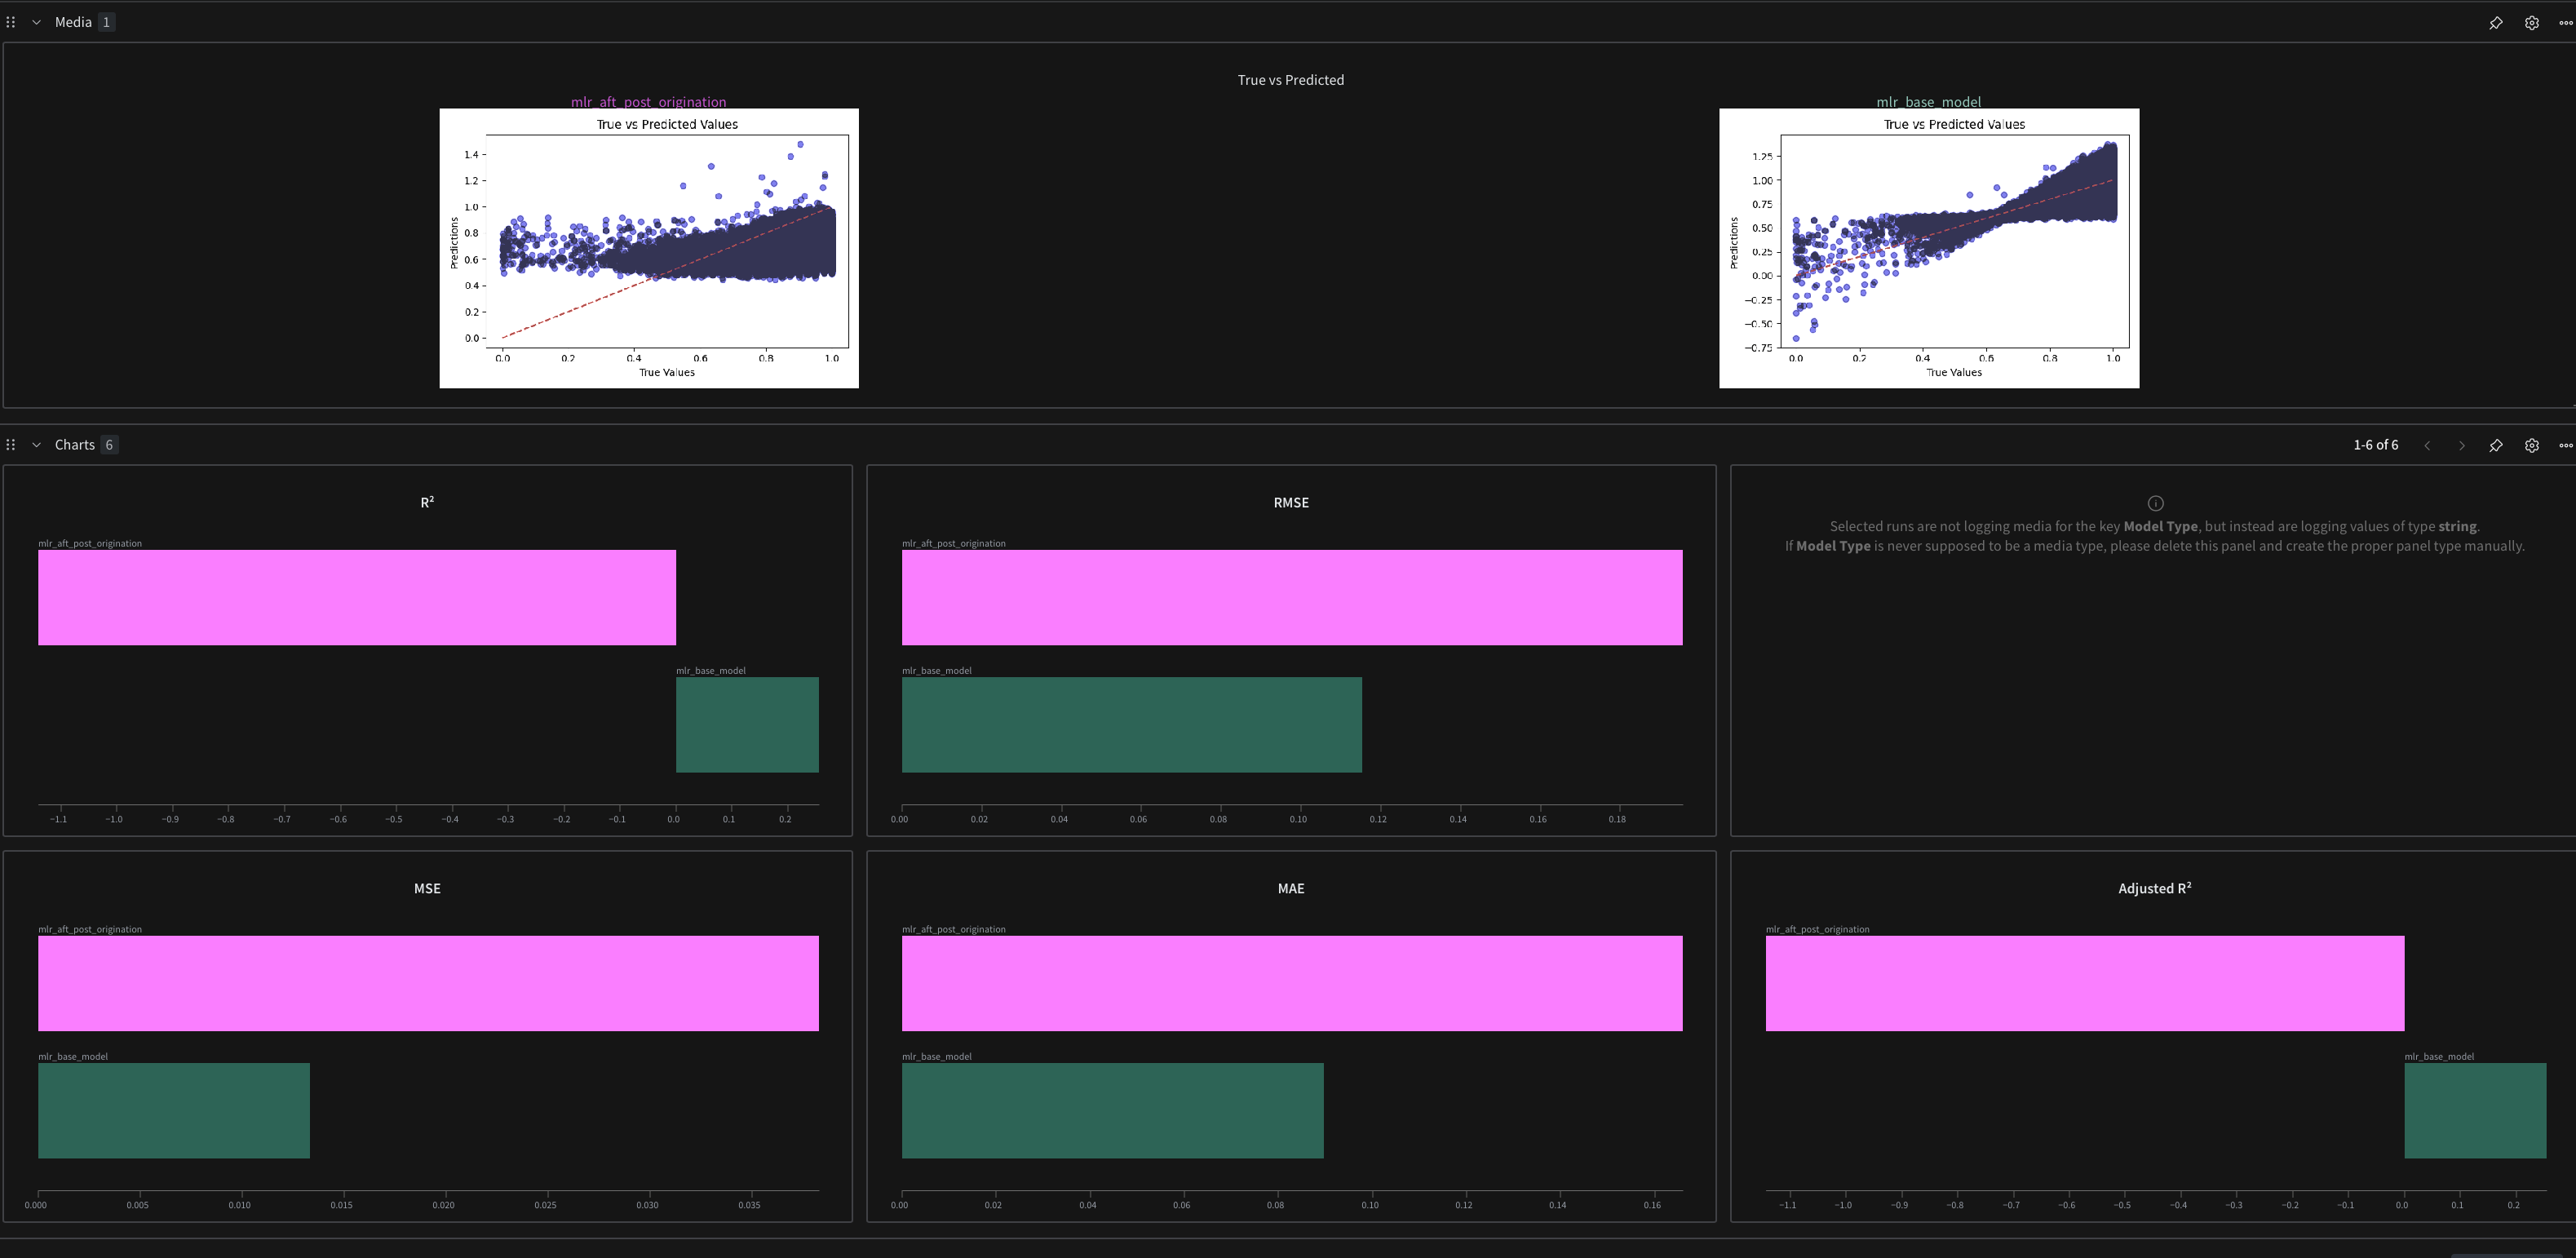


In [17]:
train_pdf_post_o.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
       '

# 2. Outlier Handling

Outliers are extreme values that can distort model training, leading to unstable predictions and poor generalization. In EAD modeling, correctly managing outliers in credit risk features—such as unusually high credit utilizations is crucial to avoid bias and overfitting. Common techniques include capping values at percentile thresholds (winsorization) or removing extreme observations or removing suspicious placeholders. Effective outlier handling ensures that the model focuses on genuine borrower behavior patterns rather than noise or errors in the data.


In [18]:
train_pdf, test_pdf = train_test_split_oot(pdf)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,ccf
139264,111227,20000.0,20000.0,36,13.43,678.08,E,6,MORTGAGE,145000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,11,682.0,0.196129
139266,118533,2500.0,2500.0,36,9.64,80.26,B,0,MORTGAGE,75000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,13,772.0,0.307668
139267,118823,2500.0,2500.0,36,12.80,84.00,D,0,MORTGAGE,32000.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,15,682.0,0.317596
139268,119043,15450.0,15450.0,36,11.22,507.46,C,2,MORTGAGE,40000.0,...,42.9,1.0,0.0,111168.0,37033.0,15000.0,31463.0,14,712.0,0.437632
139263,113179,1000.0,1000.0,36,10.59,32.55,C,2,MORTGAGE,33990.0,...,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,687.0,0.455980


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,ccf
16423,94003514,6000.0,6000.0,36,11.49,197.83,B,3,RENT,45000.0,...,25.0,0.0,0.0,50796.0,31182.0,6800.0,32496.0,12,717.0,0.806432
16422,92788154,15000.0,15000.0,36,10.49,487.47,B,3,MORTGAGE,70000.0,...,100.0,0.0,0.0,16600.0,14459.0,5900.0,0.0,19,682.0,0.621001
16421,93553214,24000.0,24000.0,60,14.99,570.84,C,10,RENT,85000.0,...,33.3,1.0,0.0,96206.0,62189.0,20000.0,64606.0,11,692.0,0.787575
16420,92522803,35000.0,35000.0,60,13.99,814.21,C,10,MORTGAGE,175000.0,...,100.0,0.0,0.0,441498.0,114546.0,26700.0,67048.0,35,712.0,0.964778
16394,92083932,11050.0,11050.0,60,22.74,309.86,E,10,RENT,72000.0,...,66.7,0.0,0.0,336877.0,30963.0,14500.0,22422.0,23,682.0,0.961226


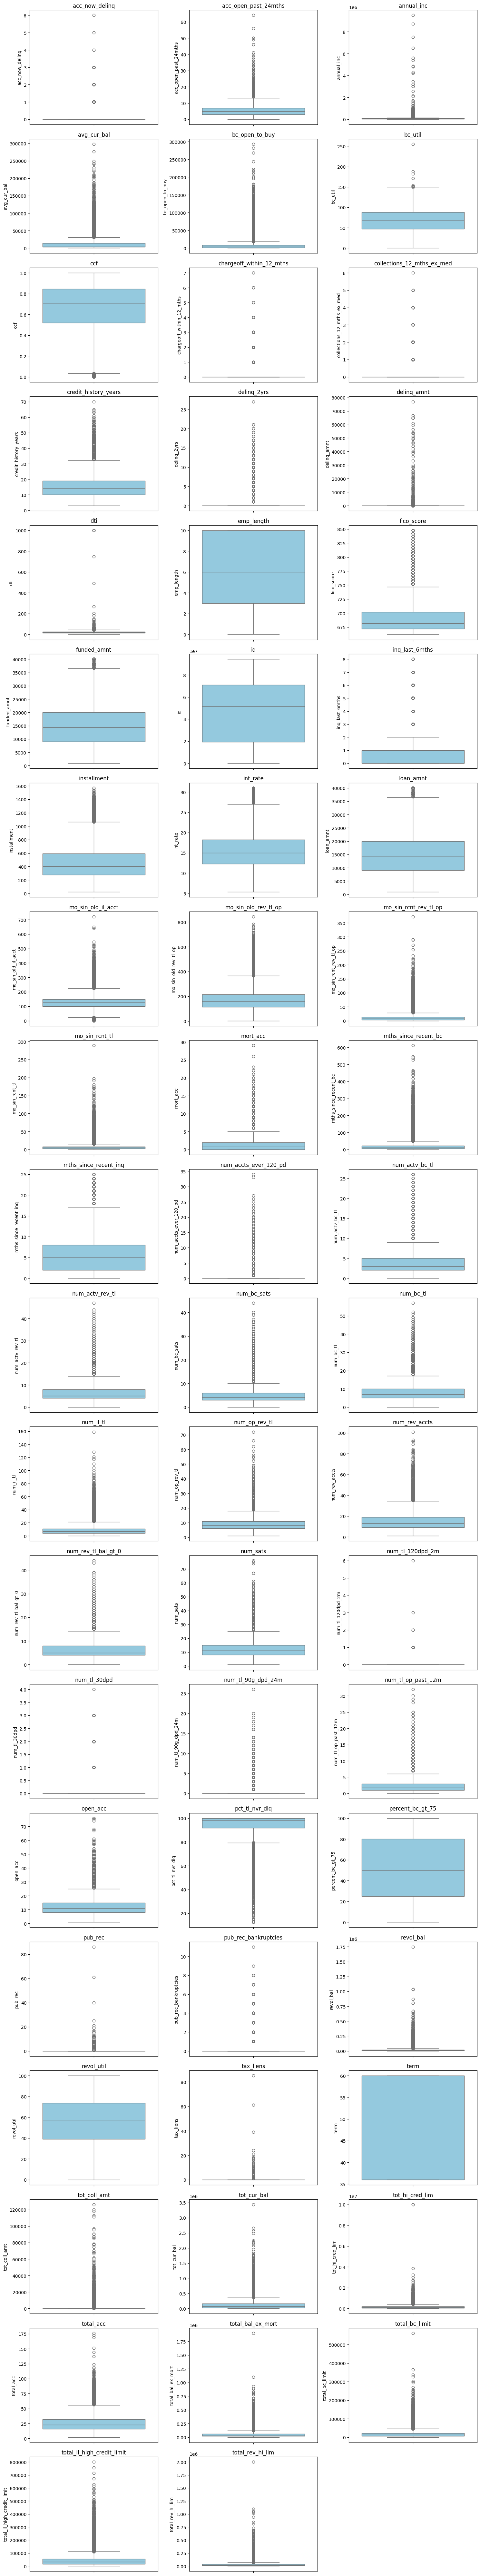

In [19]:
# ----------------------------------------
# Univariate Analysis: Outliers (Boxplot)
# ----------------------------------------


def boxplots_numeric_columns(df, max_cols=3):
    numeric_cols = sorted(df.select_dtypes(include=["number"]).columns.tolist())

    n_cols = max_cols
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color="skyblue")
        axes[i].set_title(f"{col}")
        axes[i].set_ylabel(col)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Usage example
boxplots_numeric_columns(train_pdf)

It is normal a financial dataset has a lot of outliers as shown. We will take the following steps to streamline our outlier handling process.

1. Detect & remove invalid placeholders
2. Winsorization at 1st / 99th percentile (remove worst values that can completely skew IQR Calcuations)
3. Use IQR Method to compute Outlier % -> Remove outliers till we see a more compact IQR


In [20]:
# ----------------------
# Check Outlier Values
# ----------------------
outlier_columns = sorted(list(train_pdf.columns))
inspect_outliers_pd(df=train_pdf, columns=outlier_columns, method="iqr")


📊 Inspecting Outliers for Column: `acc_now_delinq`
IQR Method | Q1=0.000, Q3=0.000, IQR=0.000
Lower Bound=0.000, Upper Bound=0.000
Outlier Count: 1187 (0.56% of valid 213644)

🔼 Top Outliers (>0.000):
174546    6
162215    5
251160    4
70215     4
57622     3
Name: acc_now_delinq, dtype: int32

📊 Inspecting Outliers for Column: `acc_open_past_24mths`
IQR Method | Q1=3.000, Q3=7.000, IQR=4.000
Lower Bound=-3.000, Upper Bound=13.000
Outlier Count: 4990 (2.34% of valid 213644)

🔼 Top Outliers (>13.000):
255507    64.0
89260     56.0
255499    50.0
42924     50.0
103109    49.0
Name: acc_open_past_24mths, dtype: float64

📊 Inspecting Outliers for Column: `annual_inc`
IQR Method | Q1=43000.000, Q3=83200.000, IQR=40200.000
Lower Bound=-17300.000, Upper Bound=143500.000
Outlier Count: 10325 (4.83% of valid 213644)

🔼 Top Outliers (>143500.000):
192730    9500000.0
61075     8706582.0
40053     7500000.0
81062     6500000.0
263685    5604824.0
Name: annual_inc, dtype: float64

📊 Inspecting O

In [21]:
# -------------------------------
# ⚠️ Detect & Remove Invalid Values
# -------------------------------

from sklearn.base import BaseEstimator, TransformerMixin

# [Min Value , Max)
valid_values_mapping = {
    "dti": [0, 101],
    "fico_score": [300, 851],
    "tot_hi_cred_lim": [0, 9999999.0],
    "mo_sin_old_il_acct": [0, 999],
    "mo_sin_old_rev_tl_op": [0, 999],
    "total_rev_hi_lim": [0, 9_999_999],
}

print(f"Initial Row Count: {train_pdf['id'].count()}")


# == Defining Classes to put in sklearn Pipeline Object ==
class InvalidValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, valid_values_dict):
        self.ref_dict = valid_values_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        valid_mask = pd.Series(True, index=X_transformed.index)  # Start with all True

        for key, value in self.ref_dict.items():
            min_val = value[0]
            max_val = value[1] - 1

            # == Keep updating boolean mask ==
            valid_mask &= valid_mask & (
                (X_transformed[key] >= min_val) & (X_transformed[key] <= max_val)
            )

        X_transformed = X_transformed.loc[valid_mask, :].copy()

        return X_transformed


invalid_values_handler = InvalidValueHandler(valid_values_mapping)
train_pdf = invalid_values_handler.fit_transform(train_pdf)
print(f"Final Row Count: {train_pdf['id'].count()}")

Initial Row Count: 213644
Final Row Count: 213624


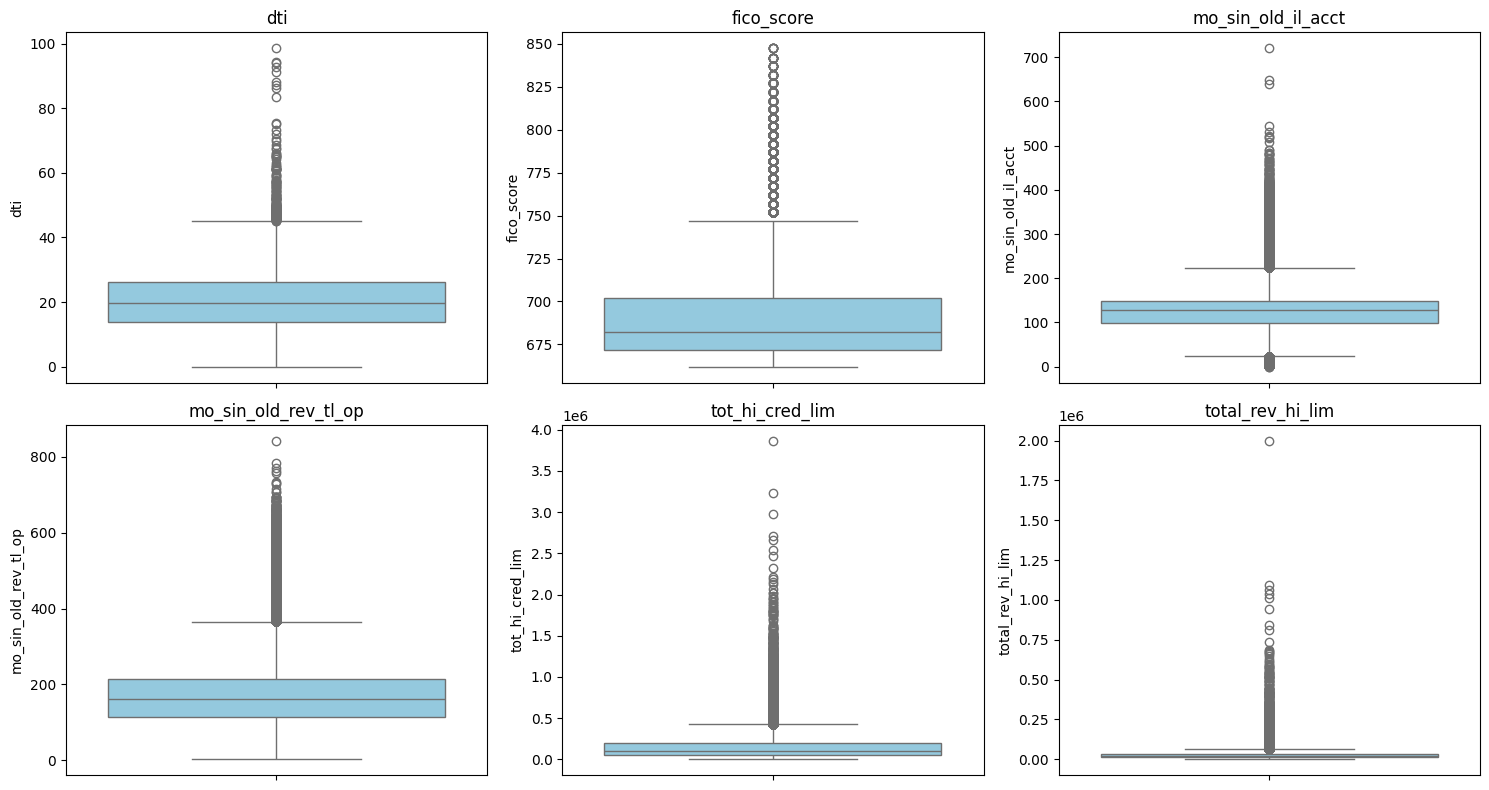

In [22]:
# ----------------------------------------
# Inspect Outliers (Boxplot Improvement)
# ----------------------------------------
boxplots_numeric_columns(train_pdf[valid_values_mapping.keys()])

We hadn't seen major improvements in the compactness of IQR. However, we can see that our `dti` is way clearer now, with our `tot_hi_cred_lim` changing its scale, which is a step towards a less extreme dataset.


In [23]:
# ------------------------------------------------
# Removal of Extreme Values at 1% & 99& Percentile
# ------------------------------------------------

print(f"Initial Row Count: {train_pdf['id'].count()}")


class ExtremeValueCapper(BaseEstimator, TransformerMixin):
    """
    Caps numeric columns at 1st and 99th percentiles learned from train data.
    """

    def __init__(self):
        pass  # No parameters needed

    def fit(self, X, y=None):
        numeric_df = X.select_dtypes(include="number")  # Select numeric columns only

        self.lower_bounds_ = numeric_df.quantile(0.01)
        self.upper_bounds_ = numeric_df.quantile(0.99)
        return self

    def transform(self, X):
        X_capped = X.copy()
        numeric_columns = X_capped.select_dtypes(include=["number"]).columns
        for col in numeric_columns:
            if col in self.lower_bounds_ and col in self.upper_bounds_:
                X_capped[col] = X_capped[col].clip(
                    lower=self.lower_bounds_[col], upper=self.upper_bounds_[col]
                )
        return X_capped


capper = ExtremeValueCapper()
train_pdf = capper.fit_transform(train_pdf)
print(f"Final Row Count: {train_pdf['id'].count()}")

Initial Row Count: 213624
Final Row Count: 213624


As seen, there are no rows, which have way too extreme values signficantly deviating from our columns' 1% & 99% percentile.


In [24]:
# -----------------------------------------------------------------
# Check Outlier Values II (After removing invalid values & capping)
# -----------------------------------------------------------------
outlier_columns = sorted(list(train_pdf.columns))
inspect_outliers_pd(df=train_pdf, columns=outlier_columns, method="iqr")


📊 Inspecting Outliers for Column: `acc_now_delinq`
IQR Method | Q1=0.000, Q3=0.000, IQR=0.000
Lower Bound=0.000, Upper Bound=0.000
Outlier Count: 0 (0.0% of valid 213624)
✅ No outliers by the chosen rule.

📊 Inspecting Outliers for Column: `acc_open_past_24mths`
IQR Method | Q1=3.000, Q3=7.000, IQR=4.000
Lower Bound=-3.000, Upper Bound=13.000
Outlier Count: 4990 (2.34% of valid 213624)

🔼 Top Outliers (>13.000):
146085    16.0
254878    16.0
254682    16.0
254746    16.0
254745    16.0
Name: acc_open_past_24mths, dtype: float64

📊 Inspecting Outliers for Column: `annual_inc`
IQR Method | Q1=43000.000, Q3=83200.000, IQR=40200.000
Lower Bound=-17300.000, Upper Bound=143500.000
Outlier Count: 10325 (4.83% of valid 213624)

🔼 Top Outliers (>143500.000):
16424     225000.0
184204    225000.0
105548    225000.0
123000    225000.0
122861    225000.0
Name: annual_inc, dtype: float64

📊 Inspecting Outliers for Column: `application_type`
⚠️ No numeric data; skipping.

📊 Inspecting Outliers for 

# 3. Skewness Handling (For Outliers)

From our boxplots, we can see that a lot of our data is right skewed, which is common for financial datasets. There are definitely some people that earn extremely high amounts or have an extremely long credit history compared to others. Since skewness can distort our model, since it destablises our model coefficient. For example, 1 or 2 outliers in annual income can possibly cause our model to assign an extremely high weightage to annual income, since the model will try to reduce error by fitting to these outliers. A small increment in annual income can then lead to a disproportionate increase in the model's prediction, violating the homoscedascity (constant variance) assumption for regression models. As such, transfromation of highly skewed variables is crucial. 

We shall now examine skewness and transform highly skewed variables by log transforming / logit transformation / box-cox based on the following workflow diagram I have compiled in Draw.IO. Should the 1st layer of transformation not work, fallbacks will be Yeo Johnson Transformation, then Quantile Binning thereafter. Such a skewness handling workflow is important to ensure extreme values in our dataset will not cause our model to be overly sensitive to extreme values.

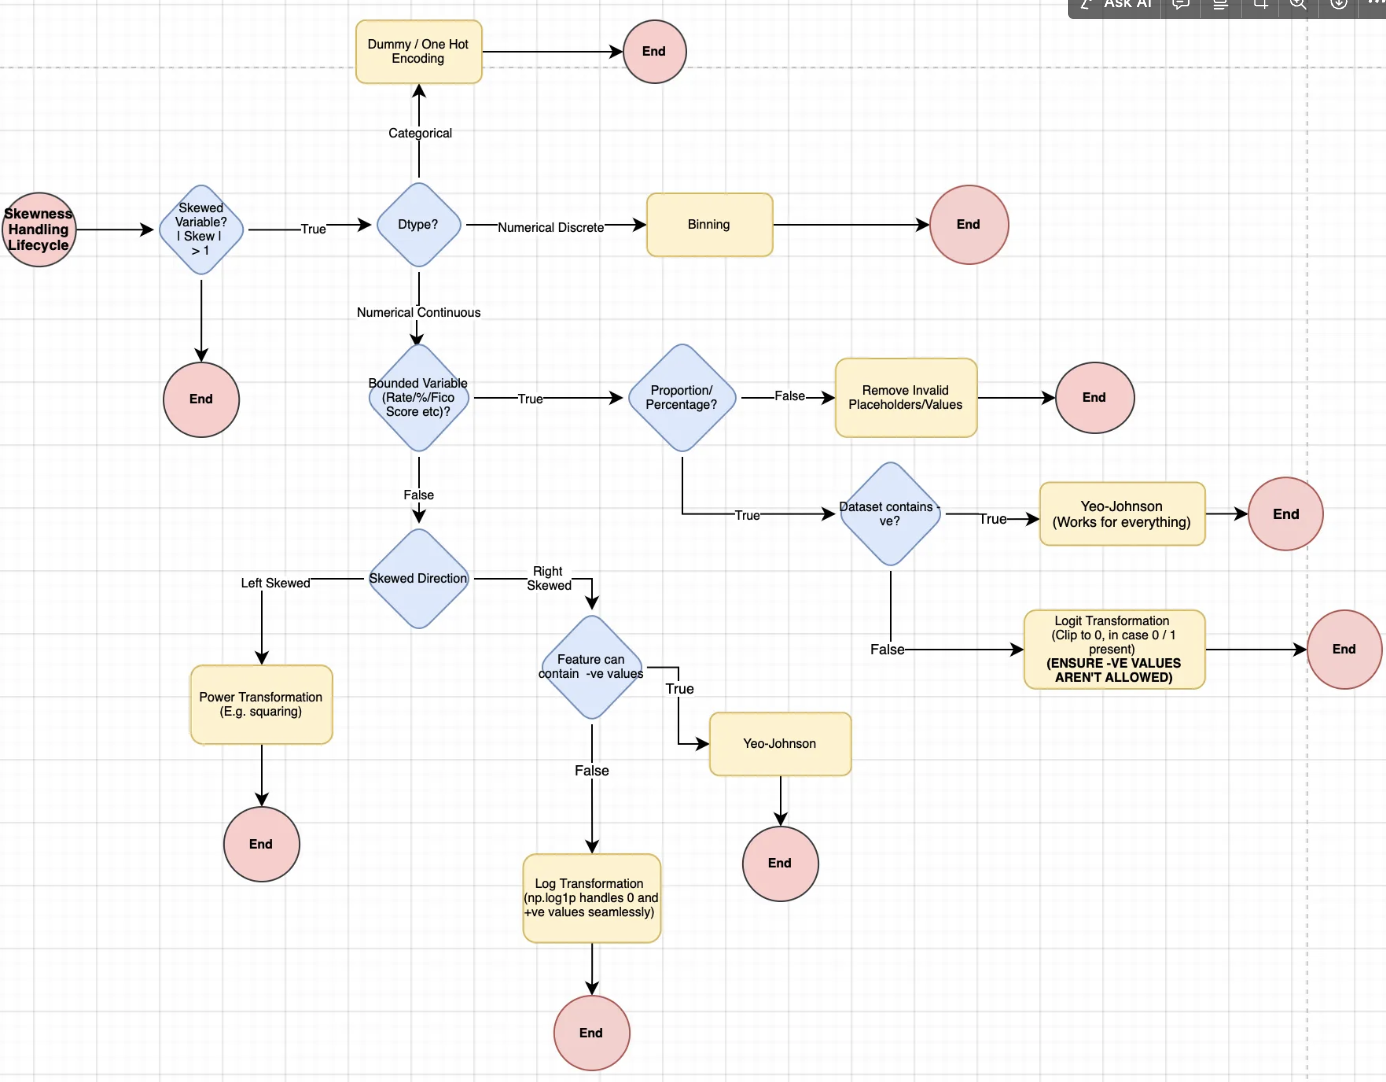